<a href="https://colab.research.google.com/github/huynguyen2703/Skimlit-Project/blob/main/TensorflowSkimLitMileStone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2 : Skimlit

The purpose of this notebokk is to build an NLP model to read medical abstracts easier.

The paper we're replicating (the source of the dataset that we will be using) is available here:
https://arxiv.org/abs/1710.06071

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?



In [ ]:
!nvidia-smi

Mon Dec 30 23:36:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Get data

Since we will be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 41.13 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
!ls pubmed-rct

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Start our experiments using the 20k datasets with numbers replaced with @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + "/" + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we got the data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, Visualize

So with that in mind, let's write a function to read in all of the lines of a target text file

In [ ]:
def get_lines(filename):
  """
  Reads a text filename and returns the lines of text as a list.

  Args:
    filename (str): target text filename.

  Returns:
    lines (list): list of text lines.
  """
  with open(filename, "r") as filename:
    lines = filename.readlines()
  return lines

In [ ]:
# Let's read in the training lines
train_lines = get_lines(filenames[2])
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

#### Let's think about how we want our data to look...
#### How I think our data would be best represented...


```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': "Emotional eating is associated with overheating and the development of obesity .\n",
  'total_lines': 11},
  ]
  ```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename)

  abstract_lines = "" # create an empty abstract to store the text
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:
    if (line.startswith("###")):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create a dict to store data from line
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1

        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(filenames[2])
val_samples = preprocess_text_with_line_numbers(filenames[0])
test_samples = preprocess_text_with_line_numbers(filenames[1])
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 440 ms, sys: 84.6 ms, total: 524 ms
Wall time: 528 ms


(180040, 30212, 30135)

In [ ]:
# Check the first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
# How about we turn our list of dictionaries into pandas DataFrame's so we visualize them better?
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

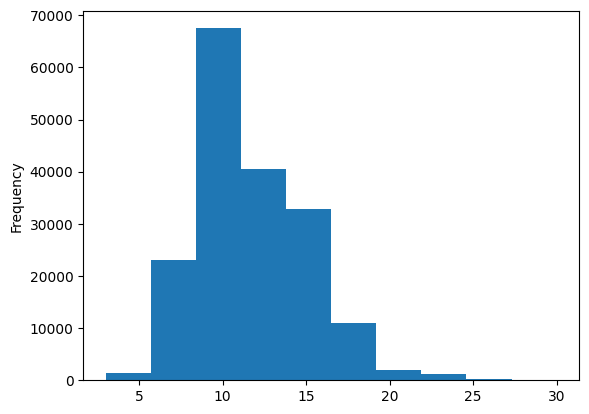

In [ ]:
# Check the length of abstract length
train_df.total_lines.plot.hist()

In [ ]:
# Convert abstract lines into lists
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)
We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels we'll use Scikit-Learn's OneHotEncoder and LabelEncoder classes.

In [ ]:
# One hot encode the labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [ ]:
# Check the one hot encoding
train_labels_one_hot[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

## Label encode labels

In [ ]:
# Extract the labels and encode them into integers (not one hot)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df["target"])
val_labels = label_encoder.transform(val_df["target"])
test_labels = label_encoder.transform(test_df["target"])

In [ ]:
# Check the label encoding
train_labels[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a series of model experiments
We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

We'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards replicating the sequence model outlined in Neural networks for joint sentence classification in medical paper abstracts.

For each model, we'll train it on the training data and evaluate it on the validation data.

## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("td-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels)

Pipeline(steps=[('td-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

In [ ]:
val_labels[:10]

array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])

#### Download helper function script to use a function to compare predictions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-12-30 23:36:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-30 23:36:49 (75.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models
Excellent! We've got a working baseline to try and improve upon.

But before we start building deeper models, we've got to create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

To start creating our vectorization and embedding layers, we'll need to import the appropriate libraries (namely TensorFlow and NumPy).

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average
sent_length = [len(sentence.split()) for sentence in train_sentences]
avg_length = np.mean(sent_length)
avg_length

26.338269273494777

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

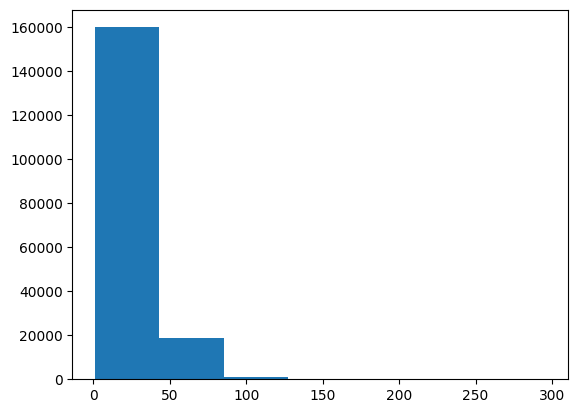

In [ ]:
# What's the distribution looks like
import matplotlib.pyplot as plt
plt.hist(sent_length, bins=7)

In [ ]:
# How long a sentence covers 95% of the lengths
output_sent_length = int(np.percentile(sent_length, 95))
output_sent_length

55

## Create text vectorizer
Now we've got a little more information about our texts, let's create a way to turn it into numbers.

To do so, we'll use the TextVectorization layer from TensorFlow.

We'll keep all the parameters default except for max_tokens (the number of unique words in our dataset) and output_sequence_length (our desired output length for each vectorized sentence).

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.



In [ ]:
# How many words are in our dictionary
from tensorflow.keras.layers import TextVectorization

max_tokens = 68000

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)




In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test our text vectorizer
import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
bis-guided titration of sevoflurane reduces the spc and decreases noradrenaline administration compared with routine care during on-pump cardiac surgery .      

Vectorized version:


<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[21089,  3166,     4,  1818,   827,     2, 10154,     3,  1073,
         8634,   288,    34,     7,   633,    77,    52,  5893,   342,
          115,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>

In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
len(rct_20k_text_vocab)
most_common_words = rct_20k_text_vocab[:10]
least_common_words = rct_20k_text_vocab[-5:]
most_common_words, least_common_words

(['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were'],
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'])

In [ ]:
# Get the config of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create custom text embedding


Our token_vectorization layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an embedding.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's Embedding layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our Embedding layer.

The input_dim parameter defines the size of our vocabulary. And the output_dim parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our text_vectorization layer as inputs and convert them to feature vectors of size output_dim.

Let's see it in action.

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name='token_embedding')

# Show example embedding
print(f"Sentence before vectorization:\n{random_sentence}\n")
vectorized_sentence = text_vectorizer([random_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
bis-guided titration of sevoflurane reduces the spc and decreases noradrenaline administration compared with routine care during on-pump cardiac surgery .

Sentence after vectorization (before embedding):
[[21089  3166     4  1818   827     2 10154     3  1073  8634   288    34
      7   633    77    52  5893   342   115     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.04057165 -0.01498958  0.0058174  ... -0.01227108 -0.01222171
   -0.0324045 ]
  [ 0.03420292  0.04611062 -0.01365412 ... -0.02545198 -0.03497149
   -0.01948918]
  [-0.04858888 -0.0333164   0.01797144 ... -0.02816777  0.02015666
    0.01234359]
  ...
  [-0.03446083  0.01108881  0.02756861 ...  0.0120682   0.03839109
   -0.00425104]
  [-0.03446083  0.01108881  0.02756861 ...  0.0120682   0

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
The main component we'll be changing throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model we're going to build is a 1-dimensional Convolutional Neural Network.

We're also going to be following the standard machine learning workflow of:

Build model
Train model
Evaluate model (make predictions and compare to ground truth)

In [ ]:
# Create 1D Convolutional model to process sequences
inputs = layers.Input(shape=(1,),
                      dtype="string")

text_vectors = text_vectorizer(inputs)

token_embeddings = token_embed(text_vectors)

conv_1d = layers.Conv1D(filters=128,
                        kernel_size=5,
                        padding="same",
                        activation="relu")(token_embeddings)

pooling_1d = layers.GlobalMaxPool1D()(conv_1d)

outputs = layers.Dense(num_classes,
                       activation="softmax")(pooling_1d)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_conv1d")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get summary of Conv1D model
model_1.summary()

Model: "model_1_conv1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,382,341 (31.98 MB)

 Trainable params: 8,382,341 (31.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int((0.1) * len(train_dataset)),
                              epochs=15,
                              validation_data=val_dataset,
                              validation_steps=int((0.1) * len(val_dataset)))

Epoch 1/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5771 - loss: 1.0517 - val_accuracy: 0.7839 - val_loss: 0.5674
Epoch 2/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7870 - loss: 0.5830 - val_accuracy: 0.7949 - val_loss: 0.5245
Epoch 3/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8019 - loss: 0.5388 - val_accuracy: 0.8128 - val_loss: 0.5074
Epoch 4/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8120 - loss: 0.5197 - val_accuracy: 0.8155 - val_loss: 0.4899
Epoch 5/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8063 - loss: 0.5320 - val_accuracy: 0.8258 - val_loss: 0.4870
Epoch 6/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8103 - loss: 0.5179 - val_accuracy: 0.8311 - val_loss: 0.4747
Epoch 7/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8183 - loss: 0.4862 - val_accuracy: 0.8198 - val_loss: 0.4895
Epoch 8/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8195 - loss: 0.4864 - val_accura

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


562/562 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.8292 - loss: 0.4791 - val_accuracy: 0.8285 - val_loss: 0.4665
Epoch 13/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8550 - loss: 0.3976 - val_accuracy: 0.8291 - val_loss: 0.4564
Epoch 14/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8678 - loss: 0.3670 - val_accuracy: 0.8172 - val_loss: 0.4826
Epoch 15/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8782 - loss: 0.3463 - val_accuracy: 0.8188 - val_loss: 0.4732


In [ ]:
# Time to make some prediction (we only trained with 10% of data)
model_1.evaluate(test_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8176 - loss: 0.5103


[0.5069549083709717, 0.8200099468231201]

In [ ]:
model_1_pred_probs = model_1.predict(test_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 1])>

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=test_labels,
                                    y_pred=model_1_preds.cpu().numpy())
model_1_results

Instructions for updating:
Use tf.identity with explicit device placement instead.


{'accuracy': 82.00099552015928,
 'precision': 0.8232652603065385,
 'recall': 0.8200099552015928,
 'f1': 0.8160518214331058}

## Model 2: Feature extraction with pretrained token embeddings
Training our own embeddings took a little while to run, slowing our experiments down.

Since we're moving towards replicating the model architecture in Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it mentions they used a pretrained GloVe embedding as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the pretrained Universal Sentence Encoder embeddings from TensorFlow Hub.

🔑 Note: We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save using pretrained GloVe embeddings as an extension.

The model structure will look like:

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
You'll notice the lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

This type of model is called transfer learning, or more specifically, feature extraction transfer learning. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

In [ ]:
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test our embedding layer on a random sentence
random_training_sentence = random.choice(train_sentences)
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])

print(f"Random training sentence:\n{random_training_sentence}\n")
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")


Random training sentence:
the aim of this study ( phase iii ) is to examine whether the improvement in adr in the trained endoscopists remained stable with further follow-up .

Sentence after embedding:
[ 0.05082898 -0.04030164 -0.02438308 -0.07224863  0.01216263 -0.03123649
  0.04266295  0.01176815  0.0467981   0.035702    0.00206606 -0.00398803
  0.06108614  0.05778272 -0.03185197  0.03165808 -0.07254282 -0.027396
  0.0373692  -0.06061097 -0.04659237  0.06081187 -0.06035595  0.02328858
 -0.02365729 -0.03790233  0.05862153  0.00467006 -0.0017626  -0.00513405] (truncated output)...

Length of sentence embedding:
512


In [ ]:
import tf_keras
model_2 = tf_keras.Sequential([
    tf_hub_embedding_layer,
    tf_keras.layers.Dense(128, activation="relu"),
    tf_keras.layers.Dense(num_classes, activation="softmax")
])


# Compile the model
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf_keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
# Fit feature extractor model for 3 epochs
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int((0.1) * len(train_dataset)),
                              epochs=15,
                              validation_data=val_dataset,
                              validation_steps=int((0.1) * len(val_dataset)))

Epoch 1/15
562/562 [==============================] - 13s 16ms/step - loss: 0.9220 - accuracy: 0.6457 - val_loss: 0.7968 - val_accuracy: 0.6875
Epoch 2/15
562/562 [==============================] - 9s 17ms/step - loss: 0.7690 - accuracy: 0.7022 - val_loss: 0.7539 - val_accuracy: 0.7041
Epoch 3/15
562/562 [==============================] - 18s 32ms/step - loss: 0.7528 - accuracy: 0.7119 - val_loss: 0.7385 - val_accuracy: 0.7131
Epoch 4/15
562/562 [==============================] - 14s 25ms/step - loss: 0.7188 - accuracy: 0.7226 - val_loss: 0.7114 - val_accuracy: 0.7281
Epoch 5/15
562/562 [==============================] - 12s 22ms/step - loss: 0.7265 - accuracy: 0.7219 - val_loss: 0.6918 - val_accuracy: 0.7307
Epoch 6/15
562/562 [==============================] - 8s 14ms/step - loss: 0.7178 - accuracy: 0.7241 - val_loss: 0.6836 - val_accuracy: 0.7340
Epoch 7/15
562/562 [==============================] - 9s 15ms/step - loss: 0.6861 - accuracy: 0.7403 - val_loss: 0.6671 - val_accuracy: 0.

562/562 [==============================] - 1s 2ms/step - loss: 0.6943 - accuracy: 0.7500 - val_loss: 0.6546 - val_accuracy: 0.7537


In [ ]:
# Evaluate model 2
model_2.evaluate(test_dataset)

942/942 [==============================] - 11s 12ms/step - loss: 0.6753 - accuracy: 0.7422


[0.6752735376358032, 0.7421934604644775]

In [ ]:
# Make prediction with model 2
model_2_pred_probs = model_2.predict(test_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

942/942 [==============================] - 12s 12ms/step


In [ ]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=test_labels,
                                    y_pred=model_2_preds.cpu().numpy())
model_2_results

{'accuracy': 74.2193462750954,
 'precision': 0.7364466304669222,
 'recall': 0.742193462750954,
 'f1': 0.7372099498727759}

In [ ]:
# Make a function to split sentences into characters
def split_texts(text):
  return " ".join(list(text))

In [ ]:
# Test split_text
split_texts(random_training_sentence)

't h e   a i m   o f   t h i s   s t u d y   (   p h a s e   i i i   )   i s   t o   e x a m i n e   w h e t h e r   t h e   i m p r o v e m e n t   i n   a d r   i n   t h e   t r a i n e d   e n d o s c o p i s t s   r e m a i n e d   s t a b l e   w i t h   f u r t h e r   f o l l o w - u p   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_texts(sentence) for sentence in train_sentences]
val_chars = [split_texts(sentence) for sentence in val_sentences]
test_chars = [split_texts(sentence) for sentence in test_sentences]

In [ ]:
# What the average character length
char_lens = [len(text) for text in train_sentences]
avg_char_length = np.mean(char_lens)
avg_char_length

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

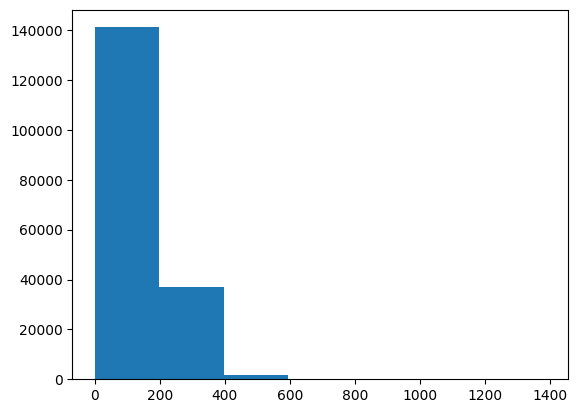

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_length = int(np.percentile(char_lens, 95))
output_seq_char_length

290

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

We'll set max_tokens (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS, # num character in alphabet + space + OOV
                                    output_sequence_length=output_seq_char_length,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)


In [ ]:
# Check character vocabulary characteristic
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
h y p o t h e s e s   w e r e   p a r t i a l l y   c o n f i r m e d   .

Length of chars: 33

Vectorized chars:
[[13 19 14  7  3 13  2  9  2  9 20  2  8  2 14  5  8  3  4  5 12 12 19 11
   7  6 17  4  8 15  2 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

## Creating a character-level embedding
We've got a way to vectorize our character-level sequences, now's time to create a character-level embedding.

Just like our custom token embedding, we can do so using the tensorflow.keras.layers.Embedding class.

Our character-level embedding layer requires an input dimension and output dimension.

The input dimension (input_dim) will be equal to the number of different characters in our char_vocab (28). And since we're following the structure of the model in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, the output dimension of the character embedding (output_dim) will be 25.

In [ ]:
# Create char embed layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25,
                              mask_zero=True, # don't use masks (this messes up model_5 if set to True)
                              )

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")


Charified text (before vectorization and embedding):
h y p o t h e s e s   w e r e   p a r t i a l l y   c o n f i r m e d   .

Embedded chars (after vectorization and embedding):
[[[ 0.03020645 -0.03507681 -0.00739597 ...  0.0169418  -0.03553839
    0.04510171]
  [ 0.02018825  0.04649992 -0.0386006  ...  0.02634496 -0.02399981
   -0.0487851 ]
  [ 0.04412926 -0.00131666 -0.0251433  ...  0.02891895  0.03099445
    0.04022316]
  ...
  [ 0.04345359  0.04855876  0.04870674 ...  0.0270118   0.02522918
    0.04166636]
  [ 0.04345359  0.04855876  0.04870674 ...  0.0270118   0.02522918
    0.04166636]
  [ 0.04345359  0.04855876  0.04870674 ...  0.0270118   0.02522918
    0.04166636]]]

Character embedding shape: (1, 290, 25)


## Building a Conv1D model to fit on character embeddings
Now we've got a way to turn our character-level sequences into numbers (char_vectorizer) as well as numerically represent them as an embedding (char_embed) let's test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as our custom token embedding model (model_1) except it'll take character-level sequences as input instead of token-level sequences.

```
Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)
```

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")

char_vectors = char_vectorizer(inputs)

char_embedding = char_embed(char_vectors)

conv_1d = layers.Conv1D(filters=128,
                        kernel_size=5,
                        padding="same",
                        activation='relu')(char_embedding)

max_pool = layers.GlobalMaxPool1D()(conv_1d)

outputs = layers.Dense(num_classes,
                       activation="softmax")(max_pool)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_char_embedding")


# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
# Check model summary
model_3.summary()

Model: "model_3_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 290, 25)             │           1,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 290, 128)            │          16,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,523 (72.36 KB)

 Trainable params: 18,523 (72.36 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=15,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4330 - loss: 1.3709 - val_accuracy: 0.6190 - val_loss: 0.9664
Epoch 2/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6205 - loss: 0.9620 - val_accuracy: 0.6652 - val_loss: 0.8734
Epoch 3/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6584 - loss: 0.8717 - val_accuracy: 0.6715 - val_loss: 0.8391
Epoch 4/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6816 - loss: 0.8249 - val_accuracy: 0.6995 - val_loss: 0.7812
Epoch 5/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6928 - loss: 0.7977 - val_accuracy: 0.6975 - val_loss: 0.7938
Epoch 6/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7039 - loss: 0.7882 - val_accuracy: 0.7201 - val_loss: 0.7254
Epoch 7/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7074 - loss: 0.7626 - val_accuracy: 0.7294 - val_loss: 0.7382
Epoch 8/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7206 - loss: 0.7418 - val_accuracy: 0.

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7245 - loss: 0.7435 - val_accuracy: 0.7470 - val_loss: 0.6837
Epoch 13/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7284 - loss: 0.7140 - val_accuracy: 0.7370 - val_loss: 0.6816
Epoch 14/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7350 - loss: 0.7042 - val_accuracy: 0.7241 - val_loss: 0.6982
Epoch 15/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7412 - loss: 0.6921 - val_accuracy: 0.7430 - val_loss: 0.6778


In [ ]:
# Make predictions with character model
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


array([[2.9905188e-01, 5.7193369e-01, 7.3377672e-03, 1.0571993e-01,
        1.5956765e-02],
       [1.1751641e-01, 8.3671653e-01, 8.6032122e-04, 3.9833121e-02,
        5.0735772e-03],
       [1.3299924e-01, 3.8624905e-02, 9.9728834e-03, 8.1609827e-01,
        2.3047442e-03],
       ...,
       [1.7061981e-03, 9.5574642e-03, 2.2338899e-02, 1.0015983e-03,
        9.6539581e-01],
       [5.7677627e-02, 1.7046829e-01, 2.5206175e-01, 1.7019920e-02,
        5.0277239e-01],
       [8.4951274e-02, 8.6235398e-01, 3.6932576e-02, 7.0459032e-03,
        8.7163001e-03]], dtype=float32)

In [ ]:
# Convert prediction to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels,
                                        y_pred=model_3_preds.cpu().numpy())
model_3_results

{'accuracy': 74.43068979213557,
 'precision': 0.7392563063494105,
 'recall': 0.7443068979213557,
 'f1': 0.7409380285569309}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In moving closer to build a model similar to the one in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it's time we tackled the hybrid token embedding layer they speak of.

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

So far we've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

Create a token-level model (similar to model_1)
Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
Combine (using layers.Concatenate) the outputs of 1 and 2
Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# Create char embed layer
char_embed_extra = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25,
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              )

token_embed_extra = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=False,
                               name='token_embedding')


# 1. Setup token inputs/model
token_input = layers.Input(shape=[], dtype="string", name="token_input")

token_vectors = text_vectorizer(token_input)

token_embedding = token_embed_extra(token_vectors)

token_output = layers.Dense(128, activation='relu')(token_embedding)

# Apply GlobalMaxPool1D to reduce the dimension of token_output
token_output = layers.GlobalMaxPool1D()(token_output)  # Reshape to (None, 128)

token_model = tf.keras.Model(token_input, token_output)

# 2 Setup char inputs/model

char_input = layers.Input(shape=(1,), dtype="string", name="char_input")

char_vectors = char_vectorizer(char_input)

char_embedding = char_embed_extra(char_vectors)

char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embedding) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf

char_model = tf.keras.Model(char_input, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)

combined_dense = layers.Dense(200, activation="relu")(combined_dropout)

final_dropout = layers.Dropout(0.5)(combined_dense)

output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_hybrid_embedding")

# Compile model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_4.summary()

Model: "model_4_hybrid_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ token_input (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 55)             │              0 │ token_input[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_embedding           │ (None, 55, 128)        │      8,299,648 │ text_vectorization[1]… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 55, 128)        │         16,512 │ token_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 290, 25)        │          1,750 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 128)            │              0 │ dense_2[0][0]          │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50)             │         10,200 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 178)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 178)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 200)            │         35,800 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 200)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 5)              │          1,005 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,364,915 (31.91 MB)

 Trainable params: 8,364,915 (31.91 MB)

 Non-trainable params: 0 (0.00 B)

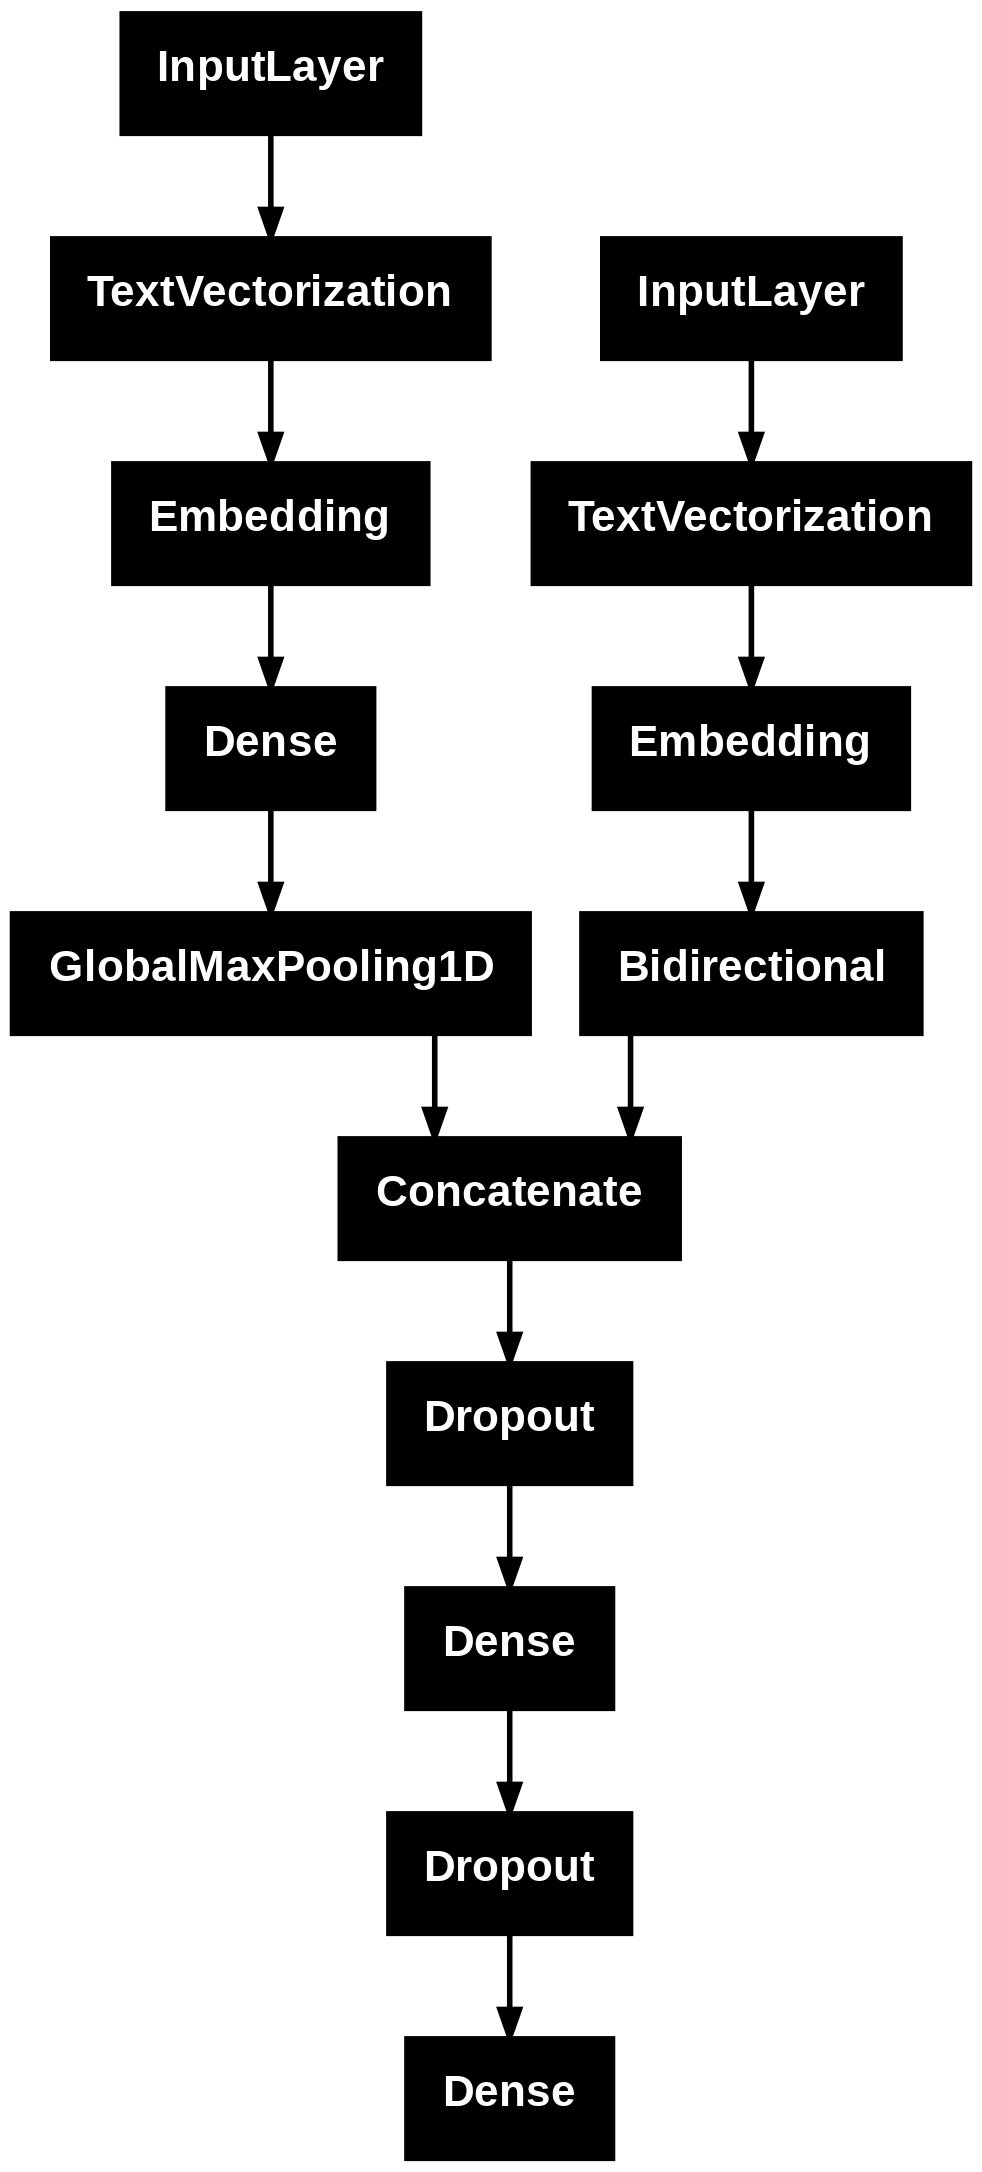

In [ ]:

# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_dataset, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=10,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))


Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.4938 - loss: 1.1948 - val_accuracy: 0.7613 - val_loss: 0.6576
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.7214 - loss: 0.7538 - val_accuracy: 0.7743 - val_loss: 0.6091
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.7388 - loss: 0.6948 - val_accuracy: 0.7849 - val_loss: 0.5865
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.7455 - loss: 0.6828 - val_accuracy: 0.7945 - val_loss: 0.5646
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.7541 - loss: 0.6683 - val_accuracy: 0.7862 - val_loss: 0.5719
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.7586 - loss: 0.6568 - val_accuracy: 0.8005 - val_loss: 0.5597
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.7629 - loss: 0.6398 - val_accuracy: 0.7869 - val_loss: 0.5577
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.7668 - loss: 0.6302 - 

In [ ]:
# Make predictions
model_4_pred_probs = model_4.predict(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


In [ ]:
# Convert into classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [ ]:
# Calculate results
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds.cpu().numpy())
model_4_results

{'accuracy': 79.72328875943334,
 'precision': 0.7977592465917778,
 'recall': 0.7972328875943334,
 'f1': 0.792876397501051}

## Model 5 : Transfer learning with pretrained token embeddings + character embeddings + positional embeddings


It seems like combining token embeddings and character embeddings gave our model a little performance boost.

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called feature engineering.

Can you think of something important about the sequences we're trying to classify?

If you were to look at an abstract, would you expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled CONCLUSIONS at the beggining and sequences labelled OBJECTIVE at the end?

Abstracts typically come in a sequential order, such as:

OBJECTIVE ...
METHODS ...
METHODS ...
METHODS ...
RESULTS ...
CONCLUSIONS ...
Or

BACKGROUND ...
OBJECTIVE ...
METHODS ...
METHODS ...
RESULTS ...
RESULTS ...
CONCLUSIONS ...
CONCLUSIONS ...
Of course, we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,

Sentence 1 of 10 ...
Sentence 2 of 10 ...
Sentence 3 of 10 ...
Sentence 4 of 10 ...
...
You might've noticed this when we created our preprocess_text_with_line_numbers() function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the "line_number" and "total_lines" columns of our DataFrames.

In [ ]:
# inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# How many different line numbers are there
train_df.line_number.value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: >

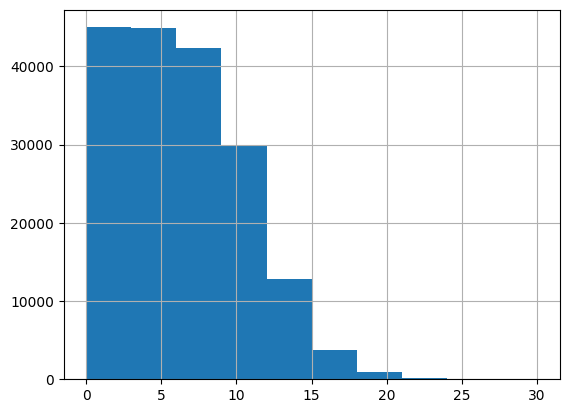

In [ ]:
# Check the distribution of "line number "
train_df.line_number.hist()

Looking at the distribution of the "line_number" column, it looks like the majority of lines have a position of 15 or less.

Knowing this, let's set the depth parameter of tf.one_hot to 15

In [ ]:
# Use Tensorflow to create one-hot-encoded tensors of line_number column
train_line_numbers_one_Hot = tf.one_hot(train_df["line_number"], depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"], depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"], depth=15)

In [ ]:
# Check one-hot encoded "line number" feature samples
train_line_numbers_one_Hot.shape, train_line_numbers_one_Hot[:5]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

In [ ]:
# How many different number of lines are there
train_df.total_lines.value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

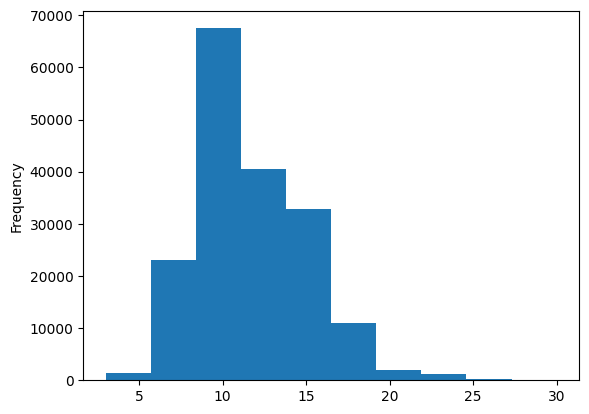

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the percentile
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use Tensorflow to create one-hot-encoded tensors of "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df.total_lines, depth=20)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines, depth=20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines, depth=20)

In [ ]:
#  Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]



(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

Building a tribrid embedding model
Woohoo! Positional embedding tensors ready.

It's time to build the biggest model we've built yet. One which incorporates token embeddings, character embeddings and our newly crafted positional embeddings.

We'll be venturing into uncovered territory but there will be nothing here you haven't practiced before.

More specifically we're going to go through the following steps:

Create a token-level model (similar to model_1)
Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
Create an output layer to accept the tribrid embedding and output predicted label probabilities
Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model
Woah! That's alot... but nothing we're not capable of. Let's code it

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_vectors = text_vectorizer(token_inputs)
token_embedding = token_embed_extra(token_vectors)
token_outputs = layers.Dense(128, activation='relu')(token_embedding)
# Apply GlobalAveragePooling1D to reduce the dimension of token_output
token_output = layers.GlobalAveragePooling1D()(token_outputs)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2 Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed_extra(char_vectors)
char_outputs = layers.Bidirectional(layers.LSTM(32))(char_embedding)
char_model = tf.keras.Model(inputs=char_inputs,
                             outputs=char_outputs)

# 3. Line number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
line_number_dense = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_dense)

# 4 Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
total_lines_dense = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_dense)

# 5 Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6 Combine positional embedding with combined token and char embeddings
z = layers.Concatenate(name="token_char_positional_embedding")([z, line_number_model.output, total_lines_model.output])

# 7 Output layer
output_layer = layers.Dense(num_classes, activation="softmax")(z)

# 8 Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 55)             │              0 │ token_inputs[0][0]     │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_embedding           │ (None, 55, 128)        │      8,299,648 │ text_vectorization[9]… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 55, 128)        │         16,512 │ token_embedding[5][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 290, 25)        │          1,750 │ char_vectorizer[2][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ dense_13[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 64)             │         14,848 │ embedding_1[4][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid_embedd… │ (None, 192)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 256)            │         49,408 │ token_char_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_input         │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_input         │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 32)             │            512 │ line_number_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)     

 Total params: 8,384,955 (31.99 MB)

 Trainable params: 8,384,955 (31.99 MB)

 Non-trainable params: 0 (0.00 B)

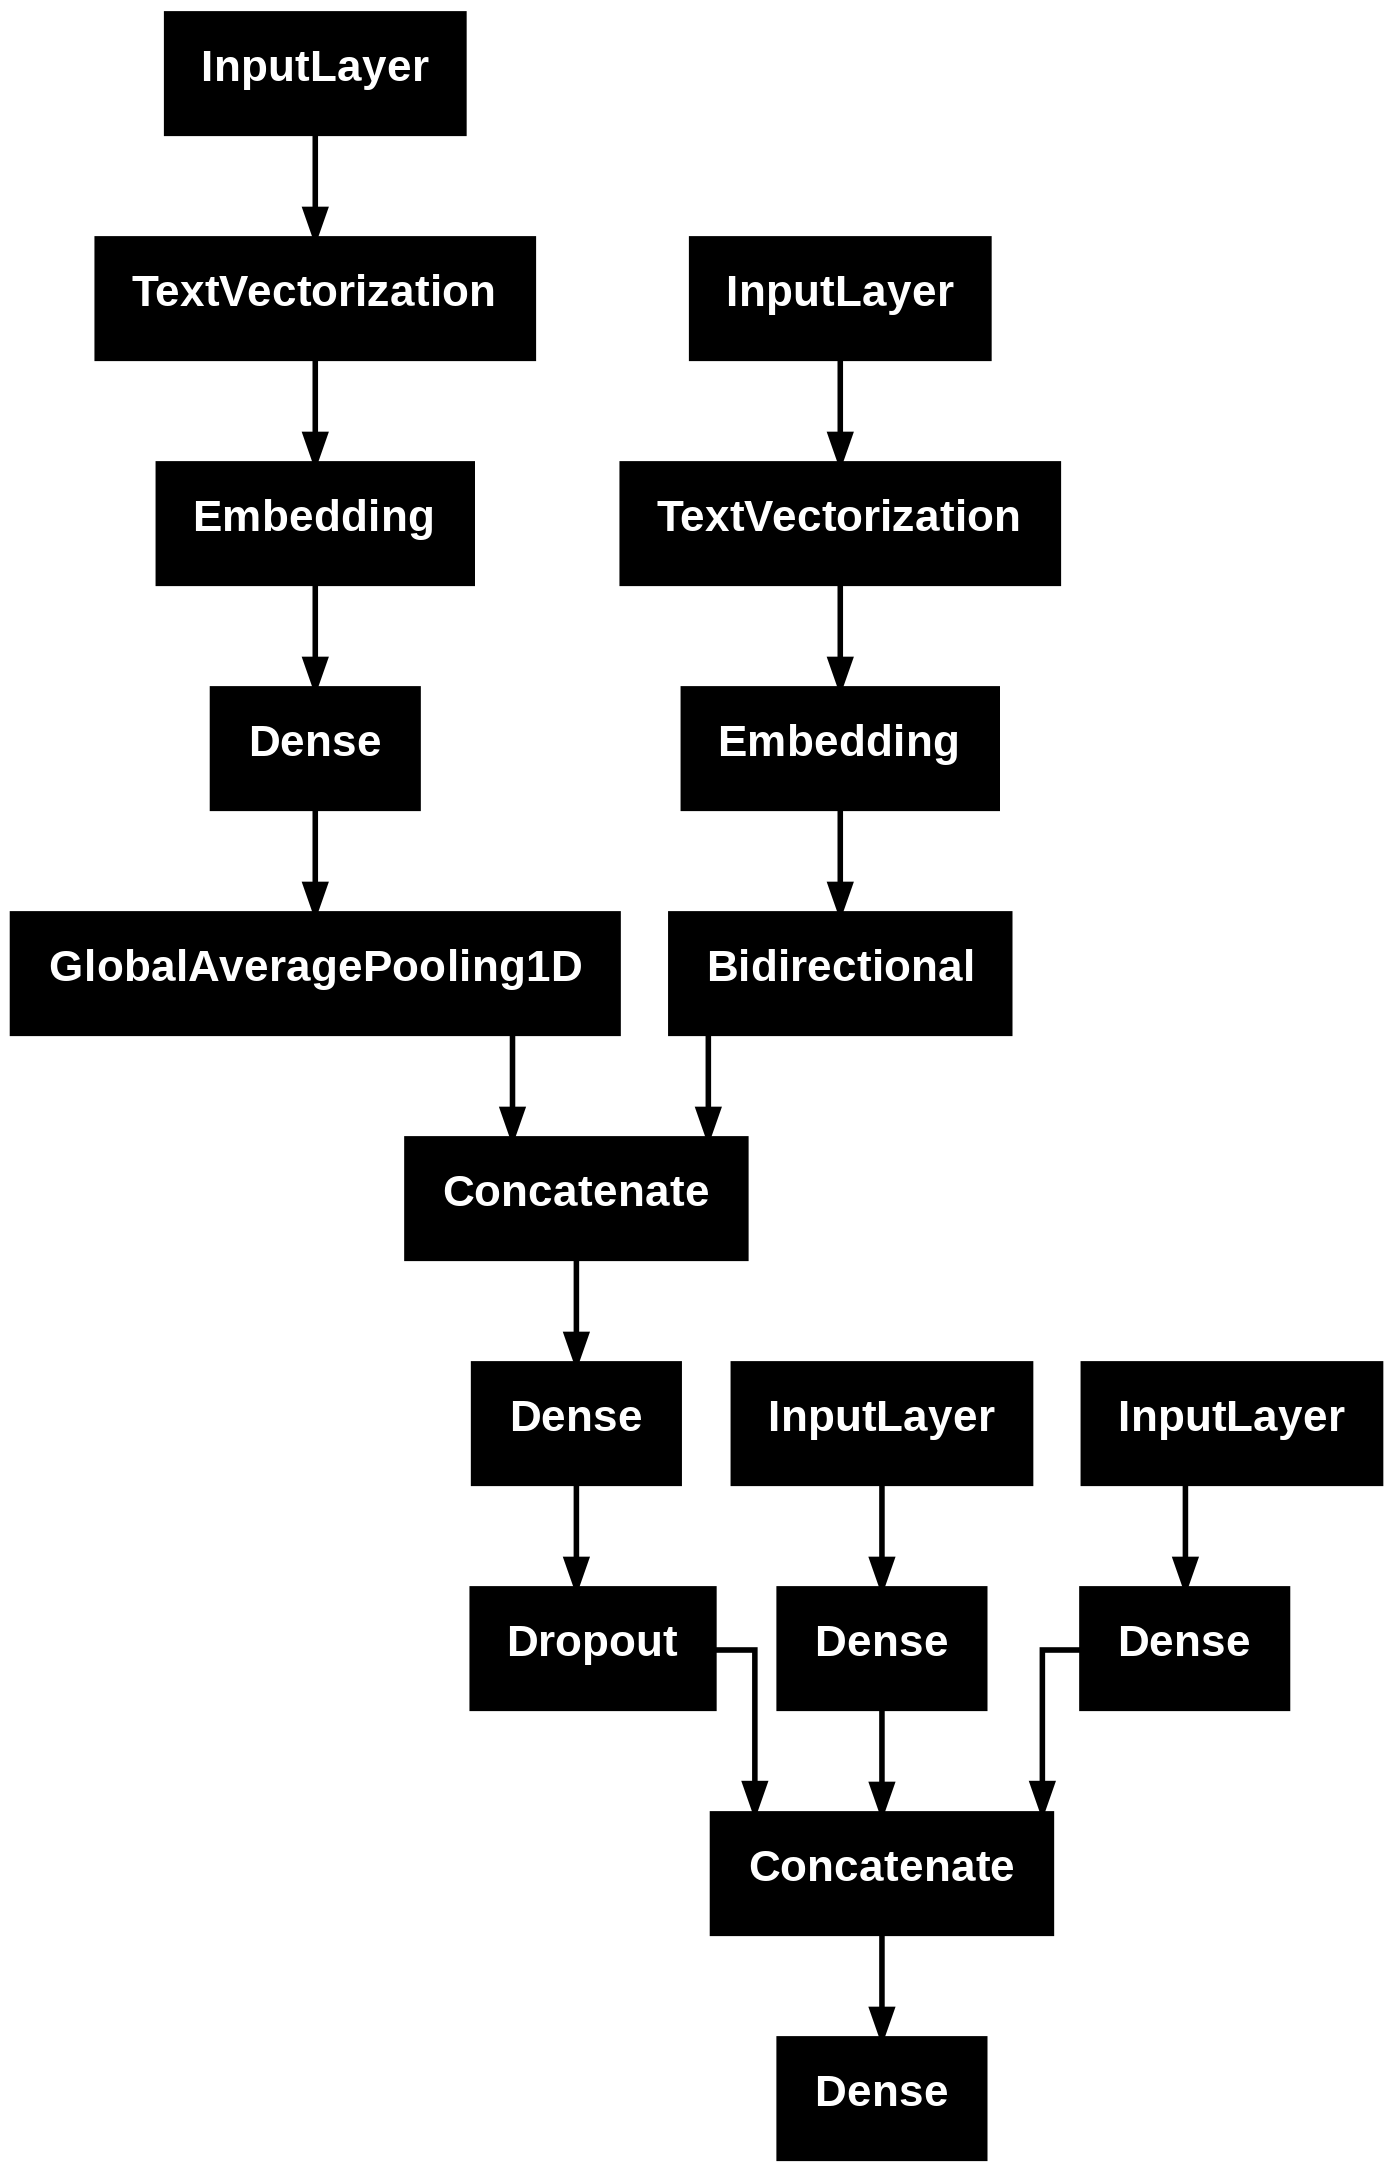

In [ ]:

# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<InputLayer name=token_inputs, built=True> True
<TextVectorization name=text_vectorization, built=True> True
<InputLayer name=char_inputs, built=True> True
<Embedding name=token_embedding, built=True> True
<TextVectorization name=char_vectorizer, built=True> True
<Dense name=dense_13, built=True> True
<Embedding name=embedding_1, built=True> True
<GlobalAveragePooling1D name=global_average_pooling1d, built=True> True
<Bidirectional name=bidirectional_4, built=True> True
<Concatenate name=token_char_hybrid_embedding, built=True> True
<Dense name=dense_16, built=True> True
<InputLayer name=line_number_input, built=True> True
<InputLayer name=total_lines_input, built=True> True
<Dropout name=dropout_2, built=True> True
<Dense name=dense_14, built=True> True
<Dense name=dense_15, built=True> True
<Concatenate name=token_char_positional_embedding, built=True> True
<Dense name=dense_17, built=True> True


In [ ]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_Hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately


In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=5,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))



Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.5933 - loss: 1.2625 - val_accuracy: 0.8338 - val_loss: 0.9449
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.8391 - loss: 0.9435 - val_accuracy: 0.8401 - val_loss: 0.9286
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.8443 - loss: 0.9269 - val_accuracy: 0.8524 - val_loss: 0.9078
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.8517 - loss: 0.9190 - val_accuracy: 0.8680 - val_loss: 0.8947
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.8534 - loss: 0.9132 - val_accuracy: 0.8637 - val_loss: 0.8914


In [ ]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step


array([[0.4551689 , 0.05821847, 0.05223232, 0.3583545 , 0.07602587],
       [0.50830746, 0.0911858 , 0.0836587 , 0.27115822, 0.04568982],
       [0.3318102 , 0.09364893, 0.07957093, 0.4608401 , 0.03412982],
       ...,
       [0.02721778, 0.06472537, 0.03450923, 0.03160401, 0.8419437 ],
       [0.0370448 , 0.53369546, 0.08184443, 0.02797902, 0.31943637],
       [0.06397422, 0.75590086, 0.04977962, 0.02510018, 0.10524514]],
      dtype=float32)

In [ ]:

# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds.cpu().numpy())
model_5_results

{'accuracy': 86.27697603601217,
 'precision': 0.8635547384173629,
 'recall': 0.8627697603601218,
 'f1': 0.8595632673129806}

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,82.000996,0.823265,0.820010,0.816052
pretrained_token_embed,74.219346,0.736447,0.742193,0.737210
custom_char_embed_conv1d,74.430690,0.739256,0.744307,0.740938
hybrid_char_token_embed,79.723289,0.797759,0.797233,0.792876
tribrid_pos_char_token_embed,86.276976,0.863555,0.862770,0.859563


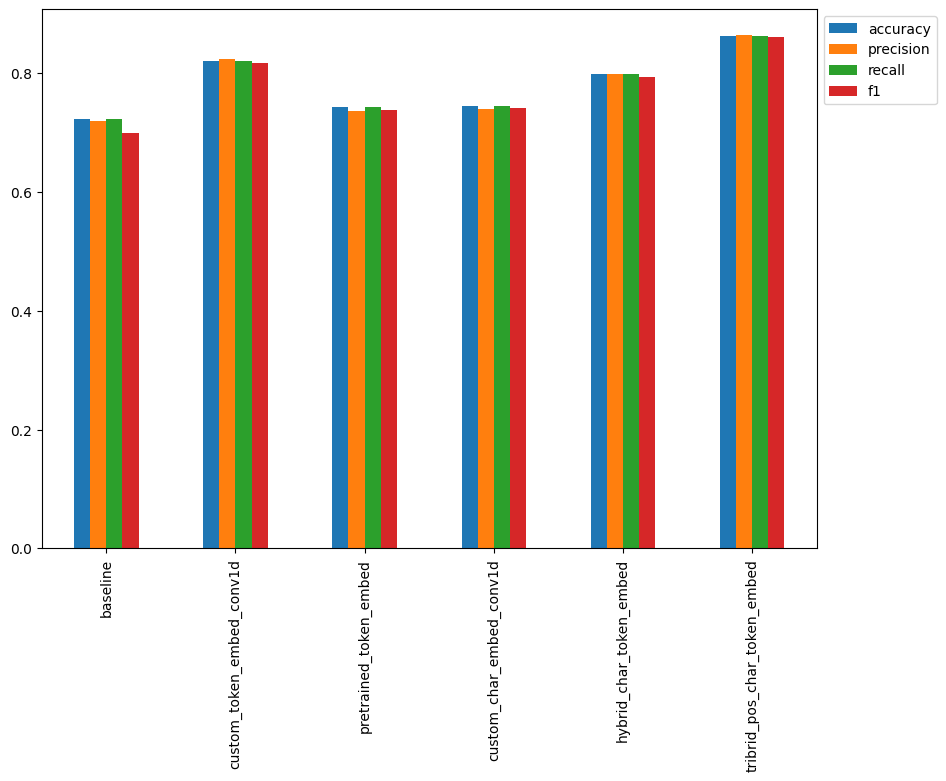

In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100


# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


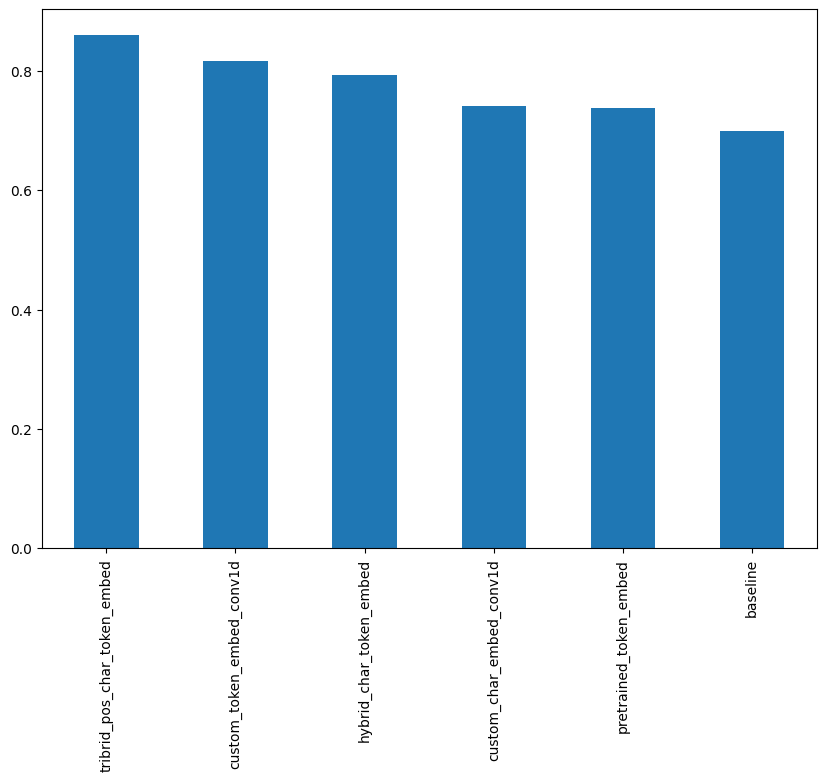

In [ ]:
# sort by F1 score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));


Nice! Based on F1-scores, it looks like our tribrid embedding model performs the best by a fair margin.

Though, in comparison to the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, our model's F1-score is still underperforming (the authors model achieves an F1-score of 90.0 on the 20k RCT dataset versus our F1-score of ~82.6).

There are some things to note about this difference:

Our models (with an exception for the baseline) have been trained on ~18,000 (10% of batches) samples of sequences and labels rather than the full ~180,000 in the 20k RCT dataset.
This is often the case in machine learning experiments though, make sure training works on a smaller number of samples, then upscale when needed (an extension to this project will be training a model on the full dataset).
Our model's prediction performance levels have been evaluated on the validation dataset not the test dataset (we'll evaluate our best model on the test dataset shortly).

In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model.keras") # model will be saved to path specified by string


In [ ]:
# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model.keras")


In [ ]:
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 2, 4, 4, 4, 1])>

In [ ]:
loaded_model_results = calculate_results(val_labels,
                                         loaded_preds.cpu().numpy())
loaded_model_results

{'accuracy': 86.27697603601217,
 'precision': 0.8635547384173629,
 'recall': 0.8627697603601218,
 'f1': 0.8595632673129806}

In [ ]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)


array([ True,  True,  True,  True])

In [ ]:
loaded_model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 55)             │              0 │ token_inputs[0][0]     │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_embedding           │ (None, 55, 128)        │      8,299,648 │ text_vectorization[0]… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 55, 128)        │         16,512 │ token_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 290, 25)        │          1,750 │ char_vectorizer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ dense_13[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 64)             │         14,848 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid_embedd… │ (None, 192)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 256)            │         49,408 │ token_char_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_input         │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_input         │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 32)             │            512 │ line_number_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)     

 Total params: 25,154,867 (95.96 MB)

 Trainable params: 8,384,955 (31.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,769,912 (63.97 MB)

In [ ]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:

# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels,
                                              y_pred=test_preds.cpu().numpy())
loaded_model_test_results

{'accuracy': 85.97643935623029,
 'precision': 0.8599509104728187,
 'recall': 0.8597643935623029,
 'f1': 0.8565047812384162}

## Make example predictions
Okay, we've made some predictions on the test dataset, now's time to really test our model out.

To do so, we're going to get some data from the wild and see how our model performs.

In other words, were going to find an RCT abstract from PubMed, preprocess the text so it works with our model, then pass each sequence in the wild abstract through our model to see what label it predicts.

For an appropriate sample, we'll need to search PubMed for RCT's (randomized controlled trials) without abstracts which have been split up (on exploring PubMed you'll notice many of the abstracts are already preformatted into separate sections, this helps dramatically with readability).

Going through various PubMed studies, I managed to find the following unstructured abstract from RCT of a manualized social treatment for high-functioning autism spectrum disorders:

This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.

Looking at the large chunk of text can seem quite intimidating. Now imagine you're a medical researcher trying to skim through the literature to find a study relevant to your work.

Sounds like quite the challenge right?

Enter SkimLit 🤓🔥!

Let's see what our best model so far (model_5) makes of the above abstract.

But wait...

As you might've guessed the above abstract hasn't been formatted in the same structure as the data our model has been trained on. Therefore, before we can make a prediction on it, we need to preprocess it just as we have our other sequences.

More specifically, for each abstract, we'll need to:

Split it into sentences (lines).
Split it into characters.
Find the number of each line.
Find the total number of lines.
Starting with number 1, there are a couple of ways to split our abstracts into actual sentences. A simple one would be to use Python's in-built split() string method, splitting the abstract wherever a fullstop appears. However, can you imagine where this might go wrong?

Another more advanced option would be to leverage spaCy's (a very powerful NLP library) sentencizer class. Which is an easy to use sentence splitter based on spaCy's English language model.

In [ ]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-12-31 00:38:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-12-31 00:38:16 (79.7 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_texts(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:

# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
CPU times: user 491 ms, sys: 11 ms, total: 502 ms
Wall time: 510 ms


array([[0.32510746, 0.08606078, 0.0685234 , 0.48627767, 0.03403062],
       [0.06646461, 0.0242292 , 0.7643119 , 0.07863005, 0.06636433],
       [0.08859529, 0.0673976 , 0.6887166 , 0.08876468, 0.06652577],
       [0.09613571, 0.15915214, 0.5679376 , 0.0690966 , 0.10767796],
       [0.03689376, 0.07524254, 0.27795425, 0.04848811, 0.56142133],
       [0.02165052, 0.07599207, 0.30878696, 0.03669355, 0.5568769 ],
       [0.01599799, 0.09870157, 0.12558022, 0.02442109, 0.7352991 ],
       [0.0142508 , 0.10214683, 0.05905911, 0.02592858, 0.7986147 ]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 4])>

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS']

In [ ]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
RESULTS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
